In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install BackTranslation
!pip install nlpaug

     |████████████████████████████████| 61kB 8.1MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 
     |████████████████████████████████| 1.2MB 33.5MB/s 
     |████████████████████████████████| 71kB 9.3MB/s 
     |████████████████████████████████| 61kB 9.0MB/s 
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-cp37-none-any.whl size=17417 sha256=33163f984994b8f20e45f953cb82160294b88b2df49bbb8178446f43d1744764
  Stored in directory: /root/.cache/pip/wheels/09/32/56/fd8940f1b3c1d77c9f91b55597c52a4d4833b000a980bb0740
Successfully built googletrans
     |████████████████████████████████| 399kB 27.5MB/s 


In [3]:
import pandas as pd
from BackTranslation import BackTranslation
import seaborn as sns
import matplotlib.pyplot as plt
from time import sleep

#If you get "AttributeError: 'Translator' object has no attribute 'raise_Exception'", change your IP adress using a VPN.


CSV_Path ="/content/drive/MyDrive/Algoritmos/Datathon/Datos/DataSet (Augmentation.test).csv"
LANG = 'en'
OLANG = 'es'
API = 'google'

def translate(df, LANG, OLANG):
    translations = {}
    trans = BackTranslation()
    
    df_en = df.copy()
    trans.raise_Exception = True

    for element in df_en['Item (Texto)'].unique():
        sleep(1)
        try:
            translations[element] =  trans.translate(element, src=OLANG, tmp = LANG).result_text
        except TypeError:
            translations[element] = element
    df_en.replace(translations, inplace = True)
    
    return df_en

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
def augmen(df):
    augmentation = {}
    aug = naw.SynonymAug(aug_src='wordnet', lang='spa')
    
    df_a = df.copy()
    df_a = df_a.drop(df_a[(df_a['GravedadMode']=='2')].index)
    df_a = df_a.drop(df_a[(df_a['GravedadMode']=='1')].index)
    df_a = df_a.drop(df_a[(df_a['GravedadMode']=='3')].index)

    for element in df_a['Item (Texto)'].unique():
        augmentation[element] =  aug.augment(element)

    df_a.replace(augmentation, inplace = True)
    
    return df_a

In [5]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw.zip.


True

In [6]:
import nlpaug.augmenter.word as naw

df = pd.read_csv(CSV_Path, header = 0)
df['GravedadMode'] = df['Gravedad'].str.split(',',expand=True).mode(axis=1, numeric_only=False, dropna=True)[0]
df['SesgoMode'] = df['Sesgo'].str.split(',',expand=True).mode(axis=1, numeric_only=False, dropna=True)[0]
df = df[['Item (Texto)', 'GravedadMode', 'SesgoMode']]
    
df2 = pd.concat([df, augmen(df)], ignore_index=True, sort=False)

In [7]:
from sklearn.model_selection import train_test_split

df = df2
x = df['Item (Texto)'].values
y = df['GravedadMode'].values
    
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size = 0.25, random_state = 0)
df2 = pd.DataFrame(columns = ['Item (Texto)' , 'GravedadMode'])
df3 = pd.DataFrame(columns = ['Item (Texto)' , 'GravedadMode'])
for i in range(len(X_train)):
  df2.loc[i] = [X_train[i],y_train[i]]
for i in range(len(X_test)):
  df3.loc[i] = [X_test[i],y_test[i]]
df_concat = pd.concat([df2, translate(df2, LANG, OLANG)], ignore_index=True, sort=False)


In [8]:
from tensorflow import keras
%tensorflow_version 2.x

In [9]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence

In [10]:
X_train = df_concat['Item (Texto)'].values
y_train = df_concat['GravedadMode'].values

X_test = df3['Item (Texto)'].values
y_test = df3['GravedadMode'].values

In [11]:
t = Tokenizer()
t.fit_on_texts(X_train)
t.fit_on_texts(X_test)

In [12]:
vocab_size = len(t.word_index) + 1
print(vocab_size)

5748


In [13]:
sequences1 = t.texts_to_sequences(X_train)
sequences2 = t.texts_to_sequences(X_test)

In [14]:
import numpy as np

np.shape(sequences1)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(368,)

In [15]:
def max_news(seq):
    for i in range(1, len(seq)):
        max_length = len(seq[0])
        if len(seq[i]) > max_length:
            max_length = len(seq[i])
    return max_length

In [16]:
news_num1 = max_news(seq = sequences1)
news_num1

89

In [17]:
news_num2 = max_news(seq = sequences2)
news_num2

110

In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_x_train = pad_sequences(sequences1, padding='pre', maxlen=max(news_num1, news_num2))
padded_x_test = pad_sequences(sequences2, padding='pre', maxlen=max(news_num1, news_num2))

In [19]:
import numpy as np

labels_train = to_categorical(np.asarray(y_train))
labels_test = to_categorical(np.asarray(y_test))

In [20]:
X_train, X_test, y_train, y_test = padded_x_train, padded_x_test, labels_train, labels_test

In [21]:
print('X_train size:', X_train.shape)
print('y_train size:', y_train.shape)
print('X_test size:', X_test.shape)
print('y_test size:', y_test.shape)

X_train size: (368, 110)
y_train size: (368, 4)
X_test size: (62, 110)
y_test size: (62, 4)


In [22]:
import os

In [23]:
cd /content/drive/MyDrive/Algoritmos/Datathon/Embeddings

/content/drive/MyDrive/Algoritmos/Datathon/Embeddings


In [24]:
ls

checkpoint/  embeddings-l-model.vec  fasttext-sbwc.300k.vec


In [ ]:
# from gensim.models import KeyedVectors
# import logging

# logging.basicConfig(format='%(asctime)s : %(message)s', level=logging.INFO)

# vectors = KeyedVectors.load_word2vec_format('embeddings-l-model.vec', binary = False)

In [25]:
import numpy as np

embeddings_index = dict()
f = open('embeddings-l-model.vec')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1313424 word vectors.


In [26]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM, Conv1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout, GlobalMaxPool1D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [27]:
# Definición del tamaño de la matriz embedding: Número de palabas únicas x dimensión del embedding (100)
embedding_matrix = np.zeros((vocab_size, 300))

# relleno de la matriz
for word, i in t.word_index.items():  # diccionario
    embedding_vector = embeddings_index.get(word) # obtención de los vectores embedded de la palabra en GloVe.
    if embedding_vector is not None:
        # adición en la matriz
        embedding_matrix[i] = embedding_vector # cada fila de la matriz.

In [28]:
keras.backend.clear_session()

# Creación de la capa embedding esando la matriz embedding predefinida.
from tensorflow.keras.layers import Embedding

# la entrada será vocab_size, y la salida 300
# para cargar los pesos de la matriz embedding hacemos trainable = False
embedding_layer = Embedding(input_dim=vocab_size, output_dim=300, weights=[embedding_matrix],
                           input_length = max(news_num1, news_num2), trainable=True)

In [29]:
from keras.wrappers.scikit_learn import KerasClassifier
es=EarlyStopping(monitor='val_loss',patience=30, restore_best_weights=True)

def create_model(neurons=20, momentum=0.9):
  mod = Sequential()
  mod.add(embedding_layer)
  mod.add(Conv1D(128, 5, activation='relu'))
  mod.add(GlobalMaxPool1D())
  mod.add(Dense(neurons, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l1(0.005),bias_regularizer='l1'))
  mod.add(Dropout(0.2))
  mod.add(Dense(neurons, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l1(0.005),bias_regularizer='l1'))
  mod.add(Dropout(0.2))
  mod.add(Dense(neurons, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l1(0.005),bias_regularizer='l1'))
  mod.add(Dropout(0.2))
  mod.add(Dense(neurons, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l1(0.005),bias_regularizer='l1'))
  mod.add(Dropout(0.2))
  mod.add(Dense(neurons, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l1(0.005),bias_regularizer='l1'))
  mod.add(Dropout(0.2))
  mod.add(Dense(neurons, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=keras.regularizers.l1(0.005),bias_regularizer='l1'))
  mod.add(Dense(4, activation='softmax'))
  opt = keras.optimizers.SGD(learning_rate=0.01, momentum=momentum, nesterov=True, clipnorm = 1, clipvalue = 0.5)
  mod.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['acc'])
  return mod

model = KerasClassifier(build_fn=create_model,epochs=500,batch_size=256, callbacks=[es])



In [ ]:
momentum = [0.1, 0.3, 0.5, 0.7, 0.9, 1]
param_grid = dict(momentum = momentum )


In [ ]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train,validation_data=(X_test, y_test))


In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.660491 using {'clipnorm': 0.5, 'clipvalue': 1}
0.222733 (0.024416) with: {'clipnorm': 0, 'clipvalue': 0}
0.233573 (0.035918) with: {'clipnorm': 0, 'clipvalue': 0.2}
0.290861 (0.026378) with: {'clipnorm': 0, 'clipvalue': 0.5}
0.209183 (0.019739) with: {'clipnorm': 0, 'clipvalue': 1}
0.288196 (0.041809) with: {'clipnorm': 0.2, 'clipvalue': 0}
0.543649 (0.044975) with: {'clipnorm': 0.2, 'clipvalue': 0.2}
0.532543 (0.219735) with: {'clipnorm': 0.2, 'clipvalue': 0.5}
0.521458 (0.154489) with: {'clipnorm': 0.2, 'clipvalue': 1}
0.217380 (0.013615) with: {'clipnorm': 0.5, 'clipvalue': 0}
0.541117 (0.128893) with: {'clipnorm': 0.5, 'clipvalue': 0.2}
0.651961 (0.096966) with: {'clipnorm': 0.5, 'clipvalue': 0.5}
0.660491 (0.093460) with: {'clipnorm': 0.5, 'clipvalue': 1}
0.290950 (0.052008) with: {'clipnorm': 1, 'clipvalue': 0}
0.630592 (0.041499) with: {'clipnorm': 1, 'clipvalue': 0.2}
0.625150 (0.135197) with: {'clipnorm': 1, 'clipvalue': 0.5}
0.641854 (0.144998) with: {'clipnorm': 1, '

In [30]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
keras.backend.clear_session()

In [31]:
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('./checkpoint',save_best_only=True, monitor='val_acc', mode='max')
#reduce_lr_acc = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=7, verbose=1, min_delta=1e-8, mode='max')


### Validation_Split

Epoch 1/700
1/1 [==============================] - 1s 1s/step - loss: 11.7148 - acc: 0.1955 - val_loss: 11.5219 - val_acc: 0.1607
INFO:tensorflow:Assets written to: ./checkpoint/assets
Epoch 2/700
1/1 [==============================] - 0s 68ms/step - loss: 11.5342 - acc: 0.2364 - val_loss: 11.4277 - val_acc: 0.1607
Epoch 3/700
1/1 [==============================] - 0s 69ms/step - loss: 11.4438 - acc: 0.2318 - val_loss: 11.3632 - val_acc: 0.1429
Epoch 4/700
1/1 [==============================] - 0s 68ms/step - loss: 11.3708 - acc: 0.2364 - val_loss: 11.3229 - val_acc: 0.3036
INFO:tensorflow:Assets written to: ./checkpoint/assets
Epoch 5/700
1/1 [==============================] - 0s 69ms/step - loss: 11.3294 - acc: 0.3091 - val_loss: 11.2989 - val_acc: 0.2857
Epoch 6/700
1/1 [==============================] - 0s 70ms/step - loss: 11.2919 - acc: 0.2864 - val_loss: 11.2823 - val_acc: 0.2857
Epoch 7/700
1/1 [==============================] - 0s 69ms/step - loss: 11.2855 - acc: 0.3409 - val_

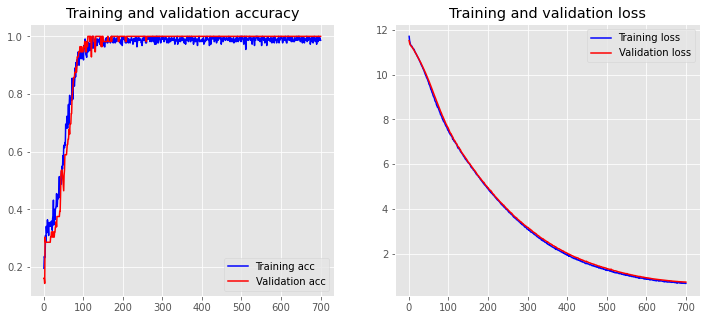

In [ ]:
es=EarlyStopping(monitor='val_loss',patience=30, restore_best_weights=True)

history = mod.fit(X_train, y_train,
                            batch_size=256,
                            epochs=700,
                            validation_split=0.2,
                            callbacks=[es,mcp_save])
loss, accuracy = mod.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = mod.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [ ]:
mod.load_weights('./checkpoint')


In [ ]:
loss, accuracy = mod.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = mod.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.5217


### Validation_data

In [32]:
keras.backend.clear_session()

Epoch 1/700
2/2 [==============================] - 2s 314ms/step - loss: 20.4847 - acc: 0.1984 - val_loss: 19.8264 - val_acc: 0.2419
INFO:tensorflow:Assets written to: ./checkpoint/assets
Epoch 2/700
2/2 [==============================] - 0s 49ms/step - loss: 19.9645 - acc: 0.1929 - val_loss: 19.7218 - val_acc: 0.2742
INFO:tensorflow:Assets written to: ./checkpoint/assets
Epoch 3/700
2/2 [==============================] - 0s 52ms/step - loss: 19.7997 - acc: 0.1902 - val_loss: 19.6617 - val_acc: 0.2903
INFO:tensorflow:Assets written to: ./checkpoint/assets
Epoch 4/700
2/2 [==============================] - 0s 63ms/step - loss: 19.6743 - acc: 0.2745 - val_loss: 19.5884 - val_acc: 0.2903
Epoch 5/700
2/2 [==============================] - 0s 49ms/step - loss: 19.6043 - acc: 0.2391 - val_loss: 19.5017 - val_acc: 0.2903
Epoch 6/700
2/2 [==============================] - 0s 49ms/step - loss: 19.4844 - acc: 0.3152 - val_loss: 19.4078 - val_acc: 0.2903
Epoch 7/700
2/2 [=========================

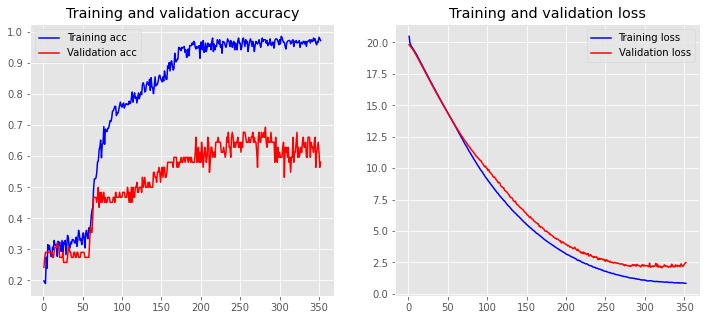

In [36]:
keras.backend.clear_session()
mod = create_model(neurons=60, momentum=0.9)

es=EarlyStopping(monitor='val_loss',patience=30, restore_best_weights=True)
mcp_save = ModelCheckpoint('./checkpoint',save_best_only=True, monitor='val_acc', mode='max')

history = mod.fit(X_train, y_train,
                            batch_size=256,
                            epochs=700,
                            validation_data=(X_test, y_test),
                            callbacks=[es,mcp_save])
loss, accuracy = mod.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = mod.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [37]:
mod.load_weights('./checkpoint')


In [38]:
loss, accuracy = mod.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = mod.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 1.0000
Testing Accuracy:  0.6935


In [64]:
y_true = np.concatenate((y_train, y_test), axis=0)
X_true = np.concatenate((X_train, X_test), axis=0)


In [65]:
from sklearn.metrics import confusion_matrix

y_pred = mod.predict(X_true)

In [66]:
y_pred = np.round(y_pred)

In [67]:
true = np.zeros(len(y_true))
for i in range(len(y_true)):
  true[i] = np.argmax(y_true[i])

pred = np.zeros(len(y_pred))
for i in range(len(y_pred)):
  pred[i] = np.argmax(y_pred[i])

In [68]:
from mlxtend.plotting import plot_confusion_matrix

def cm(y_true,y_pred):
  return plot_confusion_matrix(confusion_matrix(y_true,y_pred), cmap='Reds')

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa192533f90>)

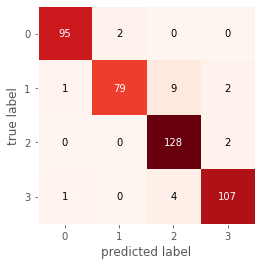

In [70]:
cm(true, pred)

In [82]:
from sklearn.metrics import precision_score
precision_score(true,pred, average='micro')

0.9511627906976744

In [83]:
from sklearn.metrics import recall_score
recall_score(true,pred, average='macro')

0.9468714597258412

In [71]:
comentario = ['El presidente en alocución oficial pronunció un discurso de odio y terror para toda la población, incitando al asesinato de todo aquel de la oposición y declarando que la única postura válida en el país era la ultraderecha.']

In [72]:
comentario = t.texts_to_sequences(comentario)


In [73]:
comentario = pad_sequences(comentario, padding = 'pre',maxlen=max(news_num1, news_num2))


In [74]:
np.argmax(mod.predict(comentario), axis=-1)

array([2])